In [3]:
import sys,os

sys.path.append('/home/arash/ProjectVR/')

import importlib
import deepsurv
import json
import time
import numpy as np
import pandas as pd
import pickle

import lasagne
import optunity

import logging
from logging import handlers
from sklearn.model_selection import train_test_split

importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger

import shap  # package used to calculate Shap values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:
    NCtrain=pickle.load(f)

network=deep_surv.load_model_from_json(model_fp = '/home/arash/ProjectVR/models/Deepwait100epochsTuned',
                     weights_fp = '/home/arash/ProjectVR/models/deepwait_weights_100_epochs.npz')

Loading json model: {"n_in": 19, "learning_rate": 0.0008208386784744157, "hidden_layers_sizes": [90, 90], "lr_decay": 0.000551240234375, "activation": "rectify", "dropout": 0.0, "batch_norm": true, "standardize": false}


In [5]:
#using train set for interpretability
dfxtrain=pd.DataFrame(xtrain[:,0:network.hyperparams['n_in']])
dfxtrain.columns=NCtrain.iloc[:,0:network.hyperparams['n_in']].columns

#seperate binary and continous variables:
binarycol = ['walktoshop','numcars_morethan1','mode_Car','over50','Age_18 - 29','Snowy',
           'Gender_Female', 'One way','mode-active', 'driving license_Yes', 'Mixed', 'Vrexp_Yes',
           'Age_30 - 39', 'FullAV','Night', 'walktowork']
contcol = ['normarrival','normdens','normlanewidth']

#using zeros as background data for binary variables, and mean value for cont variables
backgrounddata=pd.DataFrame(np.zeros(network.hyperparams['n_in'])).T         
backgrounddata.columns=NCtrain.iloc[:,0:network.hyperparams['n_in']].columns
backgrounddata[contcol]=[(dfxtrain['normarrival']).mean(),
                         (dfxtrain['normdens']).mean(),(dfxtrain['normlanewidth']).mean()] 


explainer = shap.KernelExplainer(network.predict_risk,backgrounddata)
shap_values = explainer.shap_values(dfxtrain)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
  0%|          | 0/1832 [00:00<?, ?it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  1%|          | 19/1832 [00:04<07:45,  3.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a con

 99%|█████████▉| 1818/1832 [06:28<00:03,  3.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|██████████| 1832/1832 [06:31<00:00,  4.84it/s]


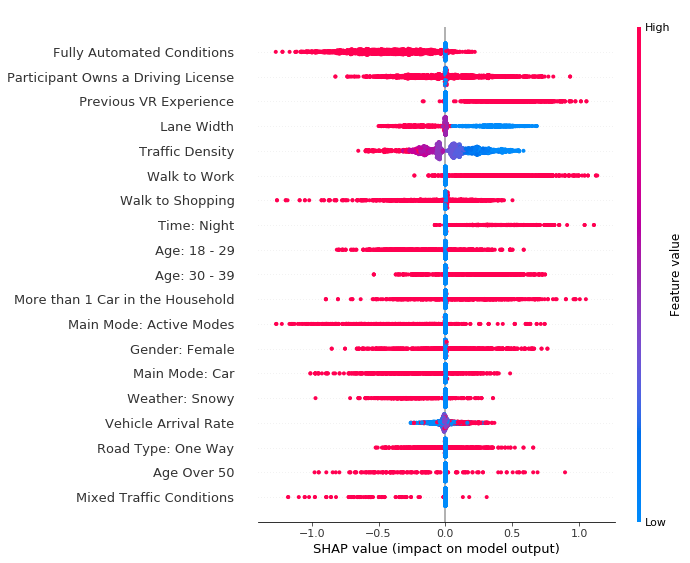

In [26]:
dfxtrain.columns=['Walk to Shopping', 'More than 1 Car in the Household', 'Main Mode: Car', 
       'Vehicle Arrival Rate', 'Age Over 50',
       'Traffic Density', ' Age: 18 - 29', ' Weather: Snowy', 'Gender: Female', 'Road Type: One Way',
       'Main Mode: Active Modes', 'Participant Owns a Driving License', 'Mixed Traffic Conditions',
       ' Previous VR Experience', 'Age: 30 - 39', 'Fully Automated Conditions', ' Lane Width',
       'Time: Night', 'Walk to Work']
shap.summary_plot(shap_values[0], dfxtrain,max_display=20)

### Create Table of Shap Values for each feature

In [7]:
def greaterthanmean(col):
    ColMean=col.mean()
    BlueIndex=col[col<=ColMean].index     #indices of feature values less than (or eq to) avg of feature
    return BlueIndex

Blues = {'normarrival': greaterthanmean(dfxtrain['normarrival']),
         'normdens': greaterthanmean(dfxtrain['normdens']),
        'normlanewidth': greaterthanmean(dfxtrain['normlanewidth'])}


shap_df = pd.DataFrame(shap_values[0], copy = True)
shap_df.columns = dfxtrain.columns
shap_df['normarrival'][Blues['normarrival']] = shap_df['normarrival'][Blues['normarrival']]*(-1)
shap_df['normdens'][Blues['normdens']] = shap_df['normdens'][Blues['normdens']]*(-1)
shap_df['normlanewidth'][Blues['normlanewidth']] = shap_df['normlanewidth'][Blues['normlanewidth']]*(-1)





mean=shap_df[shap_df!=0].mean()              #mean of shap values for each feature (non-zeros only

nonzeros=shap_df.astype(bool).sum(axis=0)        #count of non-zeros shap values for each feature

std=shap_df[shap_df!=0].std()                #standard deviation of shap values for each feature

featuresshap=pd.DataFrame()

featuresshap['count']=nonzeros
featuresshap['mean']=mean                 #bg0: zeros set as background data

featuresshap['std']=std

featuresshap['absmean']=abs(mean)

featuresshap.sort_values(by=['absmean'])

,count,mean,std,absmean
driving license_Yes,1673,-0.009217,0.282812,0.009217
One way,622,-0.025349,0.201819,0.025349
normarrival,1822,0.041003,0.084269,0.041003
Gender_Female,789,0.041379,0.296014,0.041379
walktoshop,1317,-0.072093,0.267495,0.072093
numcars_morethan1,758,0.128925,0.308825,0.128925
Age_18 - 29,864,-0.149895,0.262167,0.149895
normdens,1832,-0.189191,0.134376,0.189191
normlanewidth,1826,-0.197134,0.174416,0.197134
mode_Car,607,-0.219562,0.288102,0.219562


In [16]:
featuresshap.sort_values(by=['absmean'],ascending=False).drop(columns=['count','absmean']).to_latex(index=False)


'\\begin{tabular}{rr}\n\\toprule\n     mean &       std \\\\\n\\midrule\n-0.535410 &  0.299655 \\\\\n 0.492931 &  0.193912 \\\\\n-0.430101 &  0.272217 \\\\\n 0.423793 &  0.260193 \\\\\n 0.381095 &  0.202777 \\\\\n-0.372863 &  0.410266 \\\\\n-0.232487 &  0.179340 \\\\\n 0.231225 &  0.263909 \\\\\n-0.224146 &  0.374447 \\\\\n-0.219562 &  0.288102 \\\\\n-0.197134 &  0.174416 \\\\\n-0.189191 &  0.134376 \\\\\n-0.149895 &  0.262167 \\\\\n 0.128925 &  0.308825 \\\\\n-0.072093 &  0.267495 \\\\\n 0.041379 &  0.296014 \\\\\n 0.041003 &  0.084269 \\\\\n-0.025349 &  0.201819 \\\\\n-0.009217 &  0.282812 \\\\\n\\bottomrule\n\\end{tabular}\n'

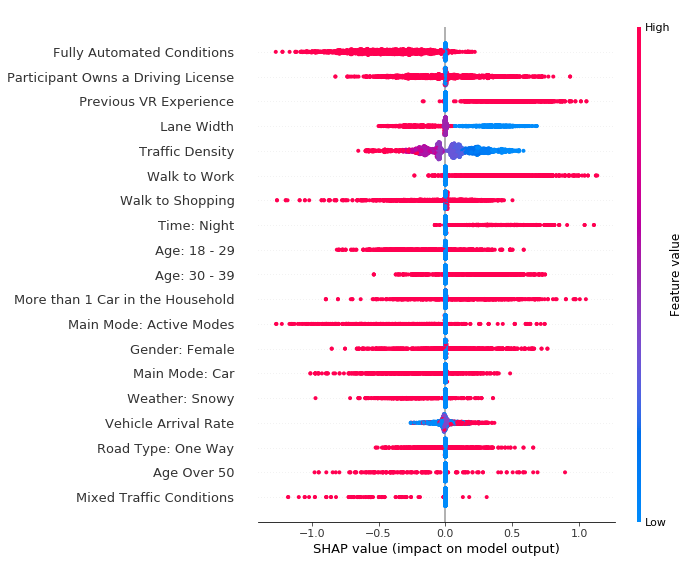

In [27]:
import matplotlib.pyplot as plt

fig = shap.summary_plot(shap_values[0], dfxtrain,max_display=20,show=False)
plt.savefig('shap', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9, 11))
plt.savefig(filename, bbox_inches = 'tight')

In [ ]:
Walk to Shopping', 'More than 1 Car in the Household

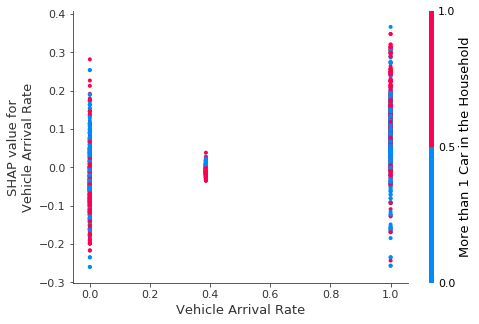

In [29]:
shap.dependence_plot(ind='Vehicle Arrival Rate', interaction_index='More than 1 Car in the Household', 
                     shap_values=shap_values[0], features=dfxtrain)